# **Indonesia Case Study 🇮🇩**

Our research examines Indonesia’s long-term economic development by focusing on the roles of capital accumulation, saving, population growth, and research and development. Institutional and cultural factors, though potentially important, are not considered in this analysis to maintain a clear focus on these key economic drivers.

This notebook serves as the coding part of the project, aiming to answer key questions related to Indonesia's economic development using provided data. It includes:

1. **Trend Calculation**: Analyses the trends for the natural logarithms of real GDP and real GDP per capita at constant 2017 national prices, with robustness checks using levels instead of log levels.

2. **Total Factor Productivity (TFP) Measure**: Derives TFP using a production function, considering real GDP, the number of employed workers, and the capital stock, while testing robustness with alternative values for the production parameter alpha.

3. **Growth Accounting**: Breaks down the contributions of input variables to changes in GDP, focusing on long-run developments rather than yearly averages.

4. **Labour Productivity**: Constructs a series for GDP per worker to study labour productivity trends.




## **1. Import Modules ⚙️** 
Load essential libraries and custom functions for data analysis and visualisation.

In [1]:
# Import modules

import numpy as np
import pandas as pd # import library for data analysis

from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns # for nicer plots (not essential)
sns.set_theme('talk', style = 'white')

import openpyxl

## **2. Data Loading and Cleaning 📈** 
We load and clean the data for our analysis in the later section.

In [2]:
# Load dataset
data = pd.read_excel('pwt100.xlsx', sheet_name = 'Data', header = 0)

In [3]:
# Clean data

# Subset relevant columns and compute per capita real GDP
# "rgdpna" represents real GDP, "pop" represents population
data = data.loc[:, ("country", "year", "rgdpna", "pop")]
data["rgdpna_pc"] = data["rgdpna"] / data["pop"]  # Calculate real GDP per capita

# Select Indonesia as the country of focus
data_indonesia = data.loc[data["country"] == "Indonesia", ("year", "rgdpna", "rgdpna_pc")]

# Reset the index for a cleaner dataset without old indexing
data_indonesia = data_indonesia.reset_index(drop=True)

# Subset the RGDP (Real GDP) and RGDP per capita series
ymax = 2019  # Set the maximum year for analysis
ymin = 1960  # Set the minimum year for analysis

# Logical indexing to filter data for the years within ymin and ymax
Y_gdp = data_indonesia.loc[np.logical_and(data_indonesia["year"] <= ymax, 
                                          data_indonesia["year"] >= ymin), "rgdpna"]
Y_pc = data_indonesia.loc[np.logical_and(data_indonesia["year"] <= ymax, 
                                         data_indonesia["year"] >= ymin), "rgdpna_pc"]

# Convert the real GDP and real GDP per capita series to logarithmic scale
# This transformation helps in interpreting growth rates as linear trends
y_gdp = np.log(Y_gdp)
y_pc = np.log(Y_pc)

# Ensure data_indonesia only contains years greater than or equal to ymin
data_indonesia = data_indonesia[data_indonesia["year"] >= ymin] 

# Compute separate sample sizes:
T_gdp = len(Y_gdp)  # Sample size for GDP data used in regression
T_pc = len(Y_pc)  # Sample size for per capita GDP data
T_all = data_indonesia["year"].max() - (ymin - 1)  # Total number of years in the dataset

# Check values to verify the sample sizes
print(T_gdp)  # Prints the number of data points for GDP
print(T_pc)  # Prints the number of data points for per capita GDP
print(T_all)  # Prints the total number of years considered


60
60
60


## **3. Project Tasks Overview**

- **3.1   Trend Calculation**:  Analyse trends for real GDP and GDP per capita (logarithms and levels) using constant 2017 national prices.

- **3.2  TFP Measure**:         Extract Total Factor Productivity using real GDP, employment, capital stock, and optionally the human capital index.

- **3.3  Growth Accounting**:   Decompose GDP growth contributions, focusing on long-term trends.

- **3.4  Labour Productivity**: Create a time series for GDP per worker.

### **3.1.1 Trend Calculation**

We analyse GDP trends using four different models to understand their fit and performance:

**(a) Additive + Linear**

**(b) Additive + Quadratic**

**(c) Exponential + Linear**

**(d) Exponential + Quadratic**


### **(a) Linear Additive**

   A simple linear trend fitted to the natural logarithm of GDP.

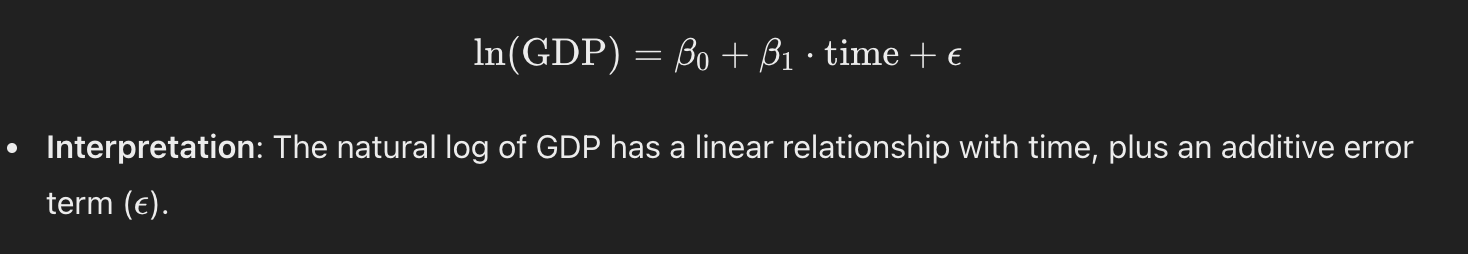



In [4]:
# Suppress runtime warnings for invalid values in log transformation
# This avoids warnings when taking the log of zero or negative values
np.seterr(invalid='ignore') 

# Additive Linear Model
# This function fits a simple linear trend model to the given time series
# The dependent variable is either RGDP (real GDP) or RGDP per capita in *levels*

def additive_linear_model(Y, T_input):
    T = len(Y)  # Number of observations in the given dataset
    
    # Initialise two empty arrays for the regressors:
    x1 = np.empty(T)  # First regressor (constant term, always 1)
    x2 = np.empty(T)  # Second regressor (time trend: 1, 2, ..., T)

    # Fill in the values for the regressors
    for t in range(T):
        x1[t] = 1.  # Constant term
        x2[t] = t + 1  # Time trend (note: Python indexing starts at 0)
        
    # Estimate the regression coefficients using the given function
    a_add_lin, b_add_lin = get_regression_coefs(Y, x1, x2)
    
    # Initialise an empty array to store predicted values
    Yhat_add_lin = np.empty(T_input)
    
    # Compute the predicted trend values for all years
    for t in range(T_input):
        Yhat_add_lin[t] = a_add_lin + b_add_lin * (t + 1)  # Recall Python starts indexing at 0
        
    # Convert the predicted values into log-units
    yhat_add_lin = np.log(Yhat_add_lin)

    return Yhat_add_lin, yhat_add_lin

# Apply the function to both RGDP and RGDP per capita time series
# This generates the estimated trend values for both variables
Yhat_add_lin_gdp, yhat_add_lin_gdp = additive_linear_model(Y_gdp, T_all)
Yhat_add_lin_pc, yhat_add_lin_pc = additive_linear_model(Y_pc, T_all)


### **(b) Additive Quadratic**

A quadratic trend fitted to the natural logarithm of GDP to account for non-linear growth patterns.

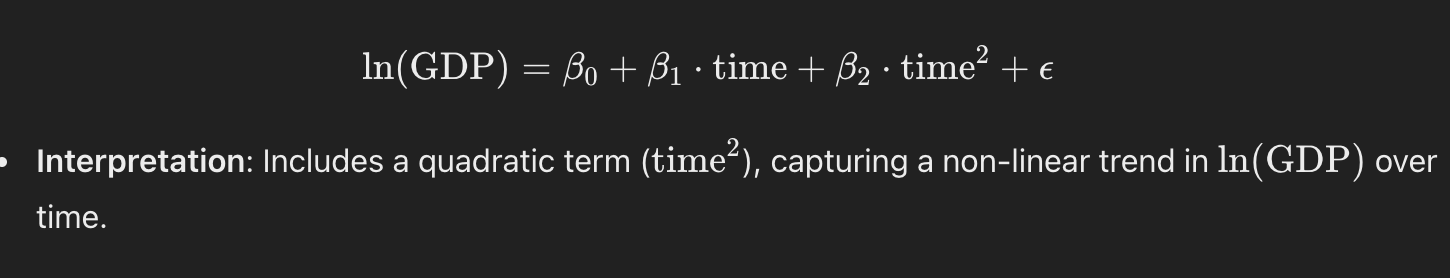

In [5]:
# Additive Quadratic Model
# This model fits a quadratic trend to the given time series data.
# The dependent variable is per capita GDP in *levels*.
# It includes three regressors:
#   - x1: Constant term (always 1)
#   - x2: Linear time trend (1, 2, 3, ..., T)
#   - x3: Quadratic time trend (1, 4, 9, ..., T^2)

def additive_quadratic_model(Y, T_input):
    T = len(Y)  # Number of observations in the dataset
    
    # Initialise three empty arrays for the regressors
    x1 = np.empty(T)  # Constant term (1)
    x2 = np.empty(T)  # Linear time trend
    x3 = np.empty(T)  # Quadratic time trend

    # Fill in the values for the regressors
    for t in range(T):
        x1[t] = 1  # Constant term
        x2[t] = t + 1  # Linear time trend (ensuring proper indexing)
        x3[t] = (t + 1) ** 2  # Quadratic time trend

    # Estimate the regression coefficients using the given function
    a_add_quad, b1_add_quad, b2_add_quad = get_regression_coefs(Y, x1, x2, x3)
    
    # Initialise an array to store predicted values
    Yhat_add_quad = np.empty(T_input)
    
    # Compute the predicted trend values for all years
    for t in range(T_input):
        Yhat_add_quad[t] = a_add_quad + b1_add_quad * (t + 1) + b2_add_quad * (t + 1) ** 2
        
    # Convert the predicted values into log-units
    # This transformation ensures that the slope of the curves represents growth rates
    yhat_add_quad = np.log(Yhat_add_quad)
    
    return Yhat_add_quad, yhat_add_quad

# Apply the function to both RGDP and RGDP per capita
# This generates the estimated quadratic trend values for both variables
Yhat_add_quad_gdp, yhat_add_quad_gdp = additive_quadratic_model(Y_gdp, T_all)
Yhat_add_quad_pc, yhat_add_quad_pc = additive_quadratic_model(Y_pc, T_all)


### **(c) Exponential Linear**

An exponential trend fitted to GDP data to capture compounding growth over time.

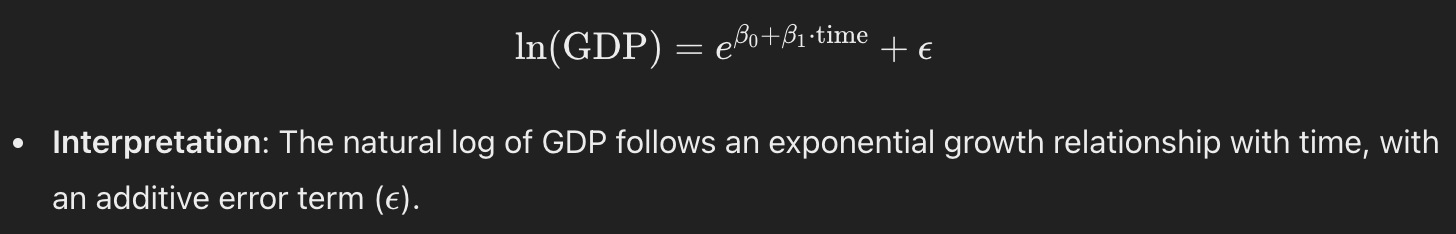

In [6]:
# Exponential Linear Model
# This model fits an exponential trend to the given time series data.
# The dependent variable is per capita GDP in *log form*.
# It includes two regressors:
#   - x1: Constant term (always 1)
#   - x2: Linear time trend (1, 2, 3, ..., T)

def exponential_linear_model(Y, T_input):
    T = len(Y)  # Number of observations in the dataset

    # Initialise two empty arrays for the regressors
    x1 = np.empty(T)  # Constant term (1)
    x2 = np.empty(T)  # Linear time trend

    # Fill in the values for the regressors
    for t in range(T):
        x1[t] = 1  # Constant term
        x2[t] = t + 1  # Linear time trend (ensuring proper indexing)

    # Transform the dependent variable into log-units to model exponential growth
    y_exp_lin = np.log(Y)

    # Estimate the regression coefficients using the given function
    a_exp_lin, b_exp_lin = get_regression_coefs(y_exp_lin, x1, x2)

    # Initialise an array to store predicted values in log-units
    yhat_exp_lin = np.empty(T_input)

    # Compute the predicted trend values for all years
    for t in range(T_input):
        yhat_exp_lin[t] = a_exp_lin + b_exp_lin * (t + 1)

    return yhat_exp_lin

# Apply the function to both RGDP and RGDP per capita
# This generates the estimated exponential trend values for both variables
yhat_exp_lin_gdp = exponential_linear_model(Y_gdp, T_all)
yhat_exp_lin_pc = exponential_linear_model(Y_pc, T_all)


### **(d) Exponential Quadratic**

An exponential trend fitted to GDP data with a quadratic term.

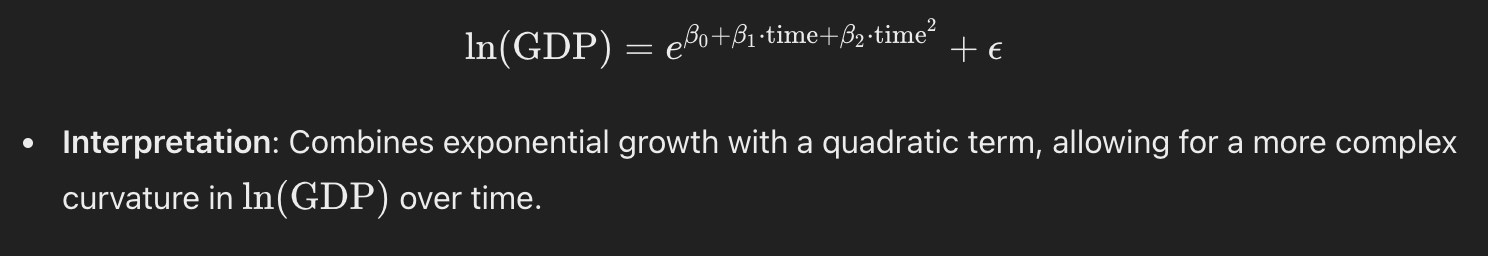

In [7]:
# Exponential Quadratic Model
# This model fits an exponential-quadratic trend to the given time series data.
# The dependent variable is per capita GDP in *log form*.
# It includes three regressors:
#   - x1: Constant term (always 1)
#   - x2: Linear time trend (1, 2, 3, ..., T)
#   - x3: Quadratic time trend (1, 4, 9, ..., T^2)

def exponential_quadratic_model(Y, T_input):
    T = len(Y)  # Number of observations in the dataset

    # Initialise three empty arrays for the regressors
    x1 = np.empty(T)  # Constant term
    x2 = np.empty(T)  # Linear time trend
    x3 = np.empty(T)  # Quadratic time trend

    # Fill in the values for the regressors
    for t in range(T):
        x1[t] = 1  # Constant term
        x2[t] = t + 1  # Linear time trend (ensuring proper indexing)
        x3[t] = (t + 1) ** 2  # Quadratic time trend

    # Transform the dependent variable into log-units to model exponential growth
    y_exp_quad = np.log(Y)

    # Estimate the regression coefficients using the given function
    a_exp_quad, b1_exp_quad, b2_exp_quad = get_regression_coefs(y_exp_quad, x1, x2, x3)

    # Initialise an array to store predicted values in log-units
    yhat_exp_quad = np.empty(T_input)

    # Compute the predicted trend values for all years
    for t in range(T_input):
        yhat_exp_quad[t] = a_exp_quad + b1_exp_quad * (t + 1) + b2_exp_quad * (t + 1) ** 2

    return yhat_exp_quad

# Apply the function to both RGDP and RGDP per capita
# This generates the estimated exponential-quadratic trend values for both variables
yhat_exp_quad_gdp = exponential_quadratic_model(Y_gdp, T_all)
yhat_exp_quad_pc = exponential_quadratic_model(Y_pc, T_all)


### **3.1.2 GDP Trends: Additive vs Exponential Models**  

The graphs compare trends in **Real GDP** and **Real GDP per capita** using additive and exponential models.  

- **Additive Models:**  
  - The **Linear Additive Model** assumes a constant rate of change in ln(GDP), while the **Quadratic Additive Model** accounts for curvature, capturing shifts in growth trends.  

- **Exponential Models:**  
  - The **Linear Exponential Model** reflects constant percentage growth, while the **Quadratic Exponential Model** introduces nonlinearity, allowing for changes in growth acceleration.  

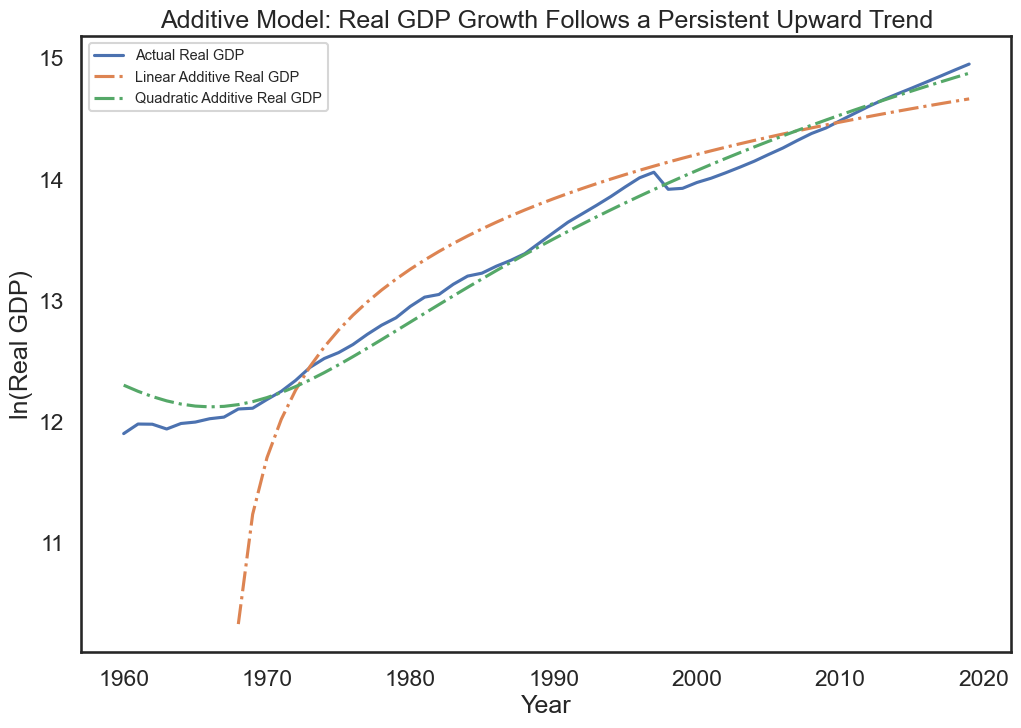

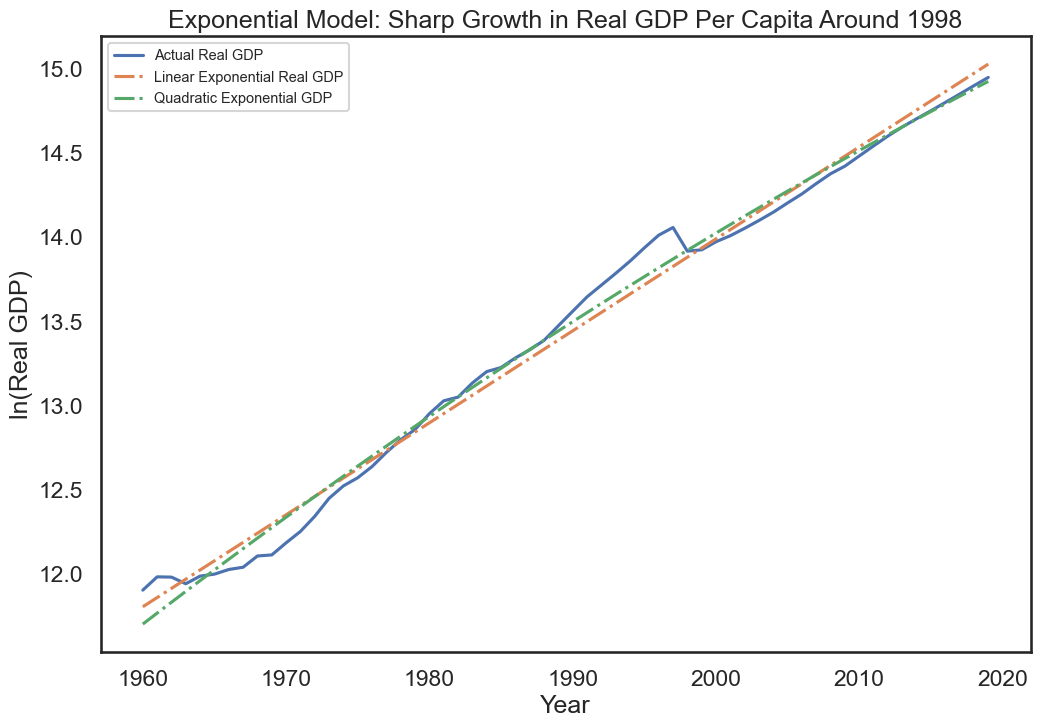

In [8]:
lw = 4  # Line width setting for consistency across plots

# Plot Additive Model for Real GDP
plt.figure(figsize=(12, 8))  # Set larger figure size for better readability

# Plot actual Real GDP (log-transformed)
plt.plot(data_indonesia['year'], np.log(data_indonesia['rgdpna']), label="Actual Real GDP")

# Plot estimated trends from additive models
plt.plot(data_indonesia['year'], yhat_add_lin_gdp, label="Linear Additive Real GDP", linestyle="dashdot")
plt.plot(data_indonesia['year'], yhat_add_quad_gdp, label="Quadratic Additive Real GDP", linestyle="dashdot")

# Labels and Title
plt.xlabel("Year")  # X-axis label
plt.ylabel("ln(Real GDP)")  # Y-axis label (log-transformed GDP)
plt.legend(fontsize='xx-small', loc='upper left')  # Small legend for clarity
plt.title("Additive Model: Real GDP Growth Follows a Persistent Upward Trend", fontsize=18)  # Informative title

# Display the plot
plt.show()

# Plot Exponential Model for Real GDP
plt.figure(figsize=(12, 8))  # Set larger figure size

# Plot actual Real GDP (log-transformed)
plt.plot(data_indonesia['year'], np.log(data_indonesia['rgdpna']), label="Actual Real GDP")

# Plot estimated trends from exponential models
plt.plot(data_indonesia['year'], yhat_exp_lin_gdp, label="Linear Exponential Real GDP", linestyle="dashdot")
plt.plot(data_indonesia['year'], yhat_exp_quad_gdp, label="Quadratic Exponential GDP", linestyle="dashdot")

# Labels and Title
plt.xlabel("Year")  # X-axis label
plt.ylabel("ln(Real GDP)")  # Y-axis label (log-transformed GDP)
plt.legend(fontsize='xx-small', loc='upper left')  # Small legend for clarity
plt.title("Exponential Model: Sharp Growth in Real GDP Per Capita Around 1998", fontsize=18)  # Informative title

# Display the plot
plt.show()


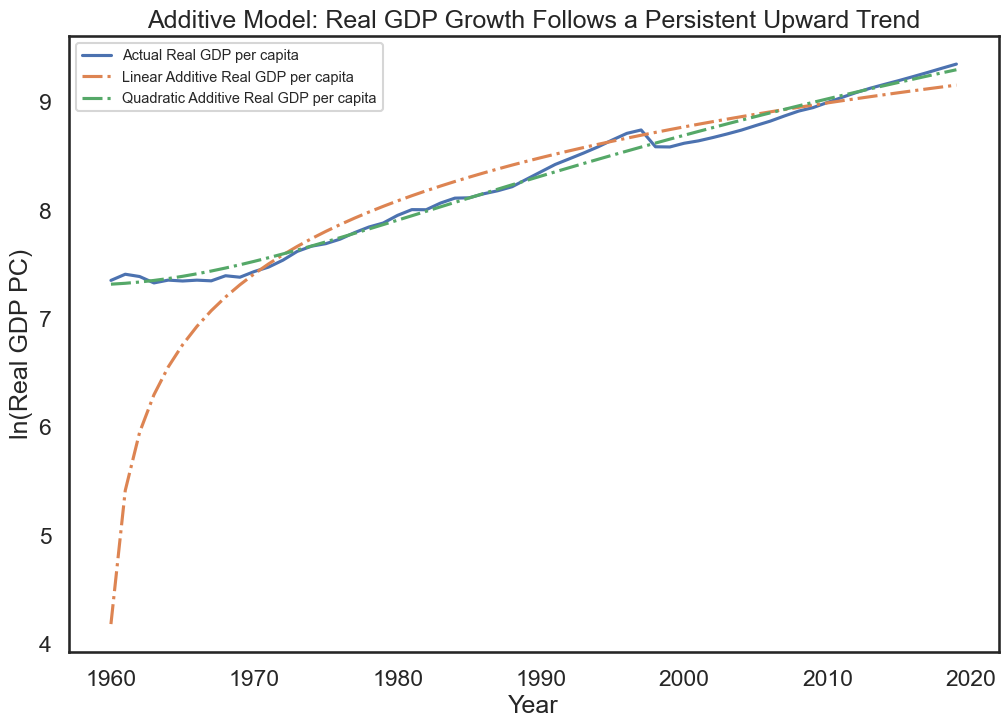

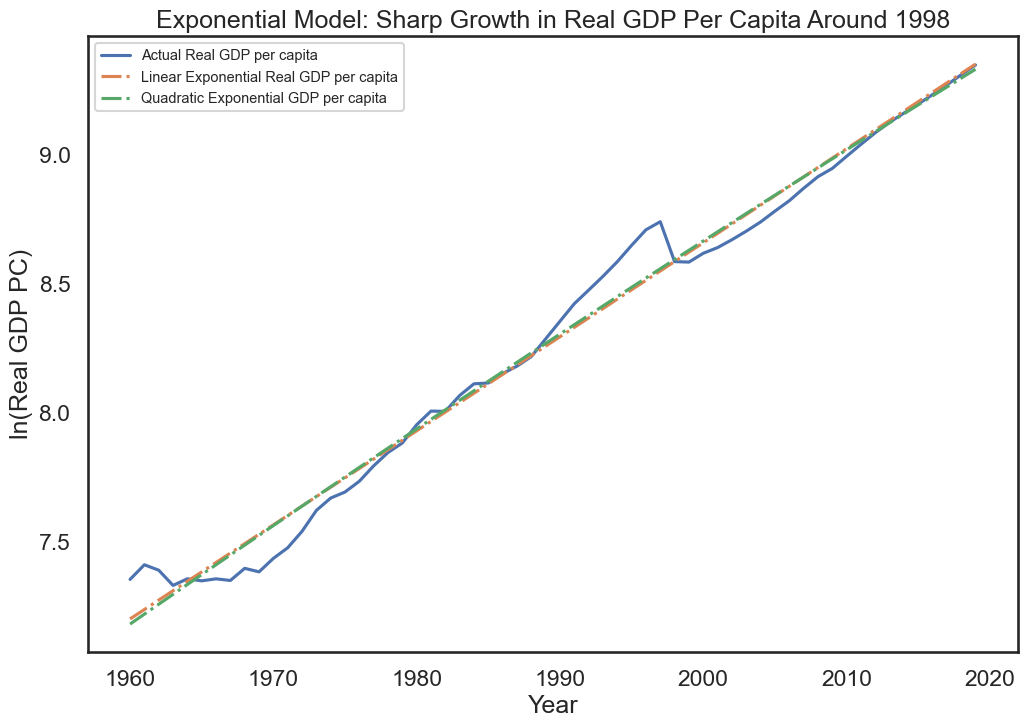

In [9]:
# Plot Additive Model for Real GDP Per Capita (RGDP PC)
plt.figure(figsize=(12, 8))  # Set a larger figure size for readability

# Plot actual Real GDP per capita (log-transformed)
plt.plot(data_indonesia['year'], np.log(data_indonesia['rgdpna_pc']), label="Actual Real GDP per capita")

# Plot estimated trends from additive models
plt.plot(data_indonesia['year'], yhat_add_lin_pc, label="Linear Additive Real GDP per capita", linestyle="dashdot")
plt.plot(data_indonesia['year'], yhat_add_quad_pc, label="Quadratic Additive Real GDP per capita", linestyle="dashdot")

# Labels and Title
plt.xlabel("Year")  # X-axis label
plt.ylabel("ln(Real GDP PC)")  # Y-axis label (log-transformed GDP per capita)
plt.legend(fontsize='xx-small', loc='upper left')  # Keep legend small but readable
plt.title("Additive Model: Real GDP Growth Follows a Persistent Upward Trend", fontsize=18)  # Informative title

# Display the plot
plt.show()

# Plot Exponential Model for Real GDP Per Capita
plt.figure(figsize=(12, 8))  # Set a larger figure size

# Plot actual Real GDP per capita (log-transformed)
plt.plot(data_indonesia['year'], np.log(data_indonesia['rgdpna_pc']), label="Actual Real GDP per capita")

# Plot estimated trends from exponential models
plt.plot(data_indonesia['year'], yhat_exp_lin_pc, label="Linear Exponential Real GDP per capita", linestyle="dashdot")
plt.plot(data_indonesia['year'], yhat_exp_quad_pc, label="Quadratic Exponential GDP per capita", linestyle="dashdot")

# Labels and Title
plt.xlabel("Year")  # X-axis label
plt.ylabel("ln(Real GDP PC)")  # Y-axis label (log-transformed GDP per capita)
plt.legend(fontsize='xx-small', loc='upper left')  # Keep legend small but readable
plt.title("Exponential Model: Sharp Growth in Real GDP Per Capita Around 1998", fontsize=18)  # Informative title

# Display the plot
plt.show()


### **3.1.3 Analyzing GDP Trends Before and After 1998**  

We chose to split the data at **1998** to analyze the impact of the **1997-1998 Asian Financial Crisis (AFC)** on Indonesia’s economy. The crisis caused **a sharp decline in GDP, severe currency depreciation, and structural policy shifts**, fundamentally altering the country's growth trajectory. By examining GDP trends before and after this period, we can assess whether Indonesia's long-term economic growth was significantly affected.  

This section splits Indonesia’s GDP data into two subperiods: **before and after 1998**, allowing us to assess structural changes in economic growth.  

- **Step 1:** The dataset is divided into two periods: **pre-1998** and **post-1998**.  
- **Step 2:** We extract **Real GDP (RGDP)** and **Real GDP per capita (RGDP PC)** for each period.  
- **Step 3:** Sample sizes for each subperiod are computed to verify the data split.  
- **Step 4:** The **Exponential Quadratic Model** is applied separately to each subperiod to estimate fitted values.  
- **Step 5:** The results are visualized to compare GDP trends before and after 1998.  

This approach helps evaluate whether Indonesia’s economic trajectory shifted significantly post-1998, capturing potential **structural breaks** in growth patterns and the economy’s recovery process.


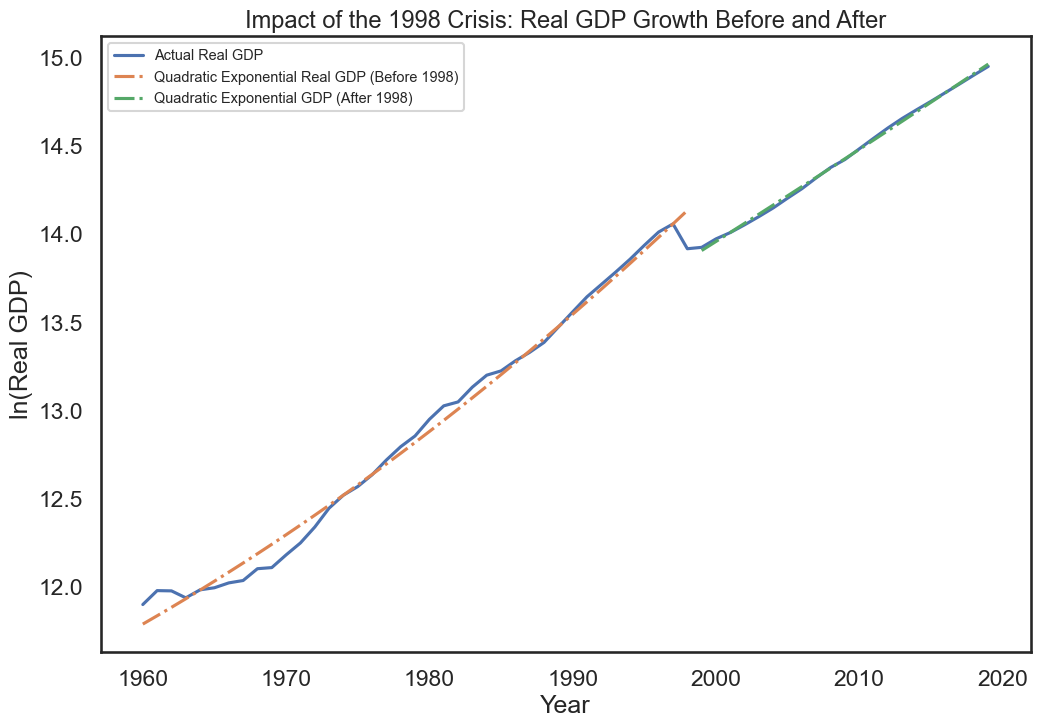

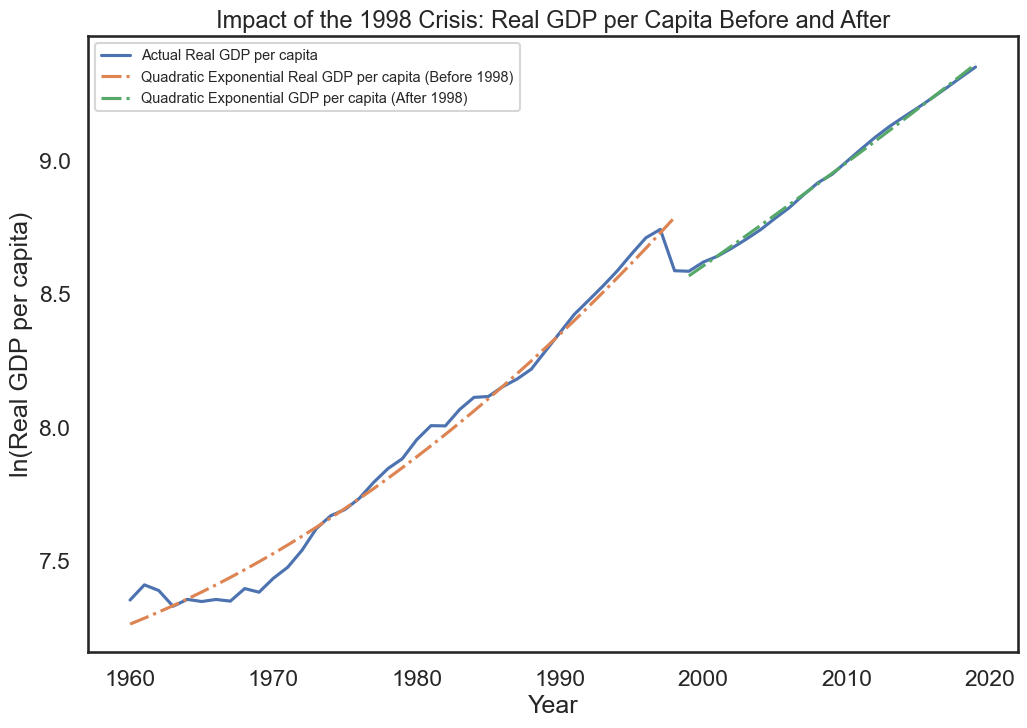

In [10]:
# Split data set into two subperiods - before and after the 1998 financial crisis
data_indonesia_before_1998 = data_indonesia[data_indonesia["year"] <= 1998]
data_indonesia_after_1998 = data_indonesia[data_indonesia["year"] > 1998]

# Subset the RGDP and RGDP per capita series for each period
Y_gdp_before_1998 = data_indonesia_before_1998["rgdpna"]
Y_gdp_after_1998 = data_indonesia_after_1998["rgdpna"]
Y_pc_before_1998 = data_indonesia_before_1998["rgdpna_pc"]
Y_pc_after_1998 = data_indonesia_after_1998["rgdpna_pc"]

# Compute sample sizes for both subperiods
T_gdp_before_1998 = len(Y_gdp_before_1998)  # Number of observations before 1998
T_gdp_after_1998 = len(Y_gdp_after_1998)  # Number of observations after 1998
T_pc_before_1998 = len(Y_pc_before_1998)  
T_pc_after_1998 = len(Y_pc_after_1998)  
T_before_1998 = 1998 - ymin + 1  # Duration of the first subperiod
T_after_1998 = ymax - 1998  # Duration of the second subperiod

# Compute the fitted values for each subperiod using the exponential quadratic model
yhat_exp_quad_gdp_before_1998 = exponential_quadratic_model(Y_gdp_before_1998, T_before_1998)
yhat_exp_quad_gdp_after_1998 = exponential_quadratic_model(Y_gdp_after_1998, T_after_1998)
yhat_exp_quad_pc_before_1998 = exponential_quadratic_model(Y_pc_before_1998, T_before_1998)
yhat_exp_quad_pc_after_1998 = exponential_quadratic_model(Y_pc_after_1998, T_after_1998)

# Plot Exponential Quadratic Model for Real GDP (RGDP)
plt.figure(figsize=(12, 8))  # Set a larger figure size for readability

# Plot actual Real GDP (log-transformed)
plt.plot(data_indonesia['year'], np.log(data_indonesia['rgdpna']), label="Actual Real GDP")

# Plot separate quadratic exponential trends for before and after 1998
plt.plot(data_indonesia_before_1998['year'], yhat_exp_quad_gdp_before_1998, 
         label="Quadratic Exponential Real GDP (Before 1998)", linestyle="dashdot")
plt.plot(data_indonesia_after_1998['year'], yhat_exp_quad_gdp_after_1998, 
         label="Quadratic Exponential GDP (After 1998)", linestyle="dashdot")

# Labels and Title
plt.xlabel("Year")  # X-axis label
plt.ylabel("ln(Real GDP)")  # Y-axis label (log-transformed GDP)
plt.legend(fontsize='xx-small', loc='upper left')  # Keep legend small but readable
plt.title("Impact of the 1998 Crisis: Real GDP Growth Before and After", fontsize=17)  # Informative title

# Show the plot
plt.show()

# Plot Exponential Quadratic Model for Real GDP per Capita (RGDP PC)
plt.figure(figsize=(12, 8))  # Set a larger figure size for readability

# Plot actual Real GDP per capita (log-transformed)
plt.plot(data_indonesia['year'], np.log(data_indonesia['rgdpna_pc']), label="Actual Real GDP per capita")

# Plot separate quadratic exponential trends for before and after 1998
plt.plot(data_indonesia_before_1998['year'], yhat_exp_quad_pc_before_1998, 
         label="Quadratic Exponential Real GDP per capita (Before 1998)", linestyle="dashdot")
plt.plot(data_indonesia_after_1998['year'], yhat_exp_quad_pc_after_1998, 
         label="Quadratic Exponential GDP per capita (After 1998)", linestyle="dashdot")

# Labels and Title
plt.xlabel("Year")  # X-axis label
plt.ylabel("ln(Real GDP per capita)")  # Y-axis label (log-transformed GDP per capita)
plt.legend(fontsize='xx-small', loc='upper left')  # Keep legend small but readable
plt.title("Impact of the 1998 Crisis: Real GDP per Capita Before and After", fontsize=17)  # Informative title

# Show the plot
plt.show()


### **3.2 Total Factor Productivity (TFP) Measure**  

#### **Why Include Human Capital (hc)?**  
We included **hc (human capital index)** because **labour quality matters as much as labour quantity**. 

Education and skills make workers more productive, meaning two countries with the same number of workers can have very different output per worker if one has a more skilled workforce.  

By incorporating **hc**, we account for differences in worker skill levels rather than assuming all workers contribute equally to production.  

##### **Importance for Growth Accounting**  
Without **hc**, any differences in productivity would be attributed entirely to **Total Factor Productivity (TFP)**, which includes **technology, policies, and institutions**. 

This could make it harder to identify the real drivers of growth.  

By including **hc**, we can better separate the role of **human capital** from other factors, making our analysis **more precise and meaningful**.

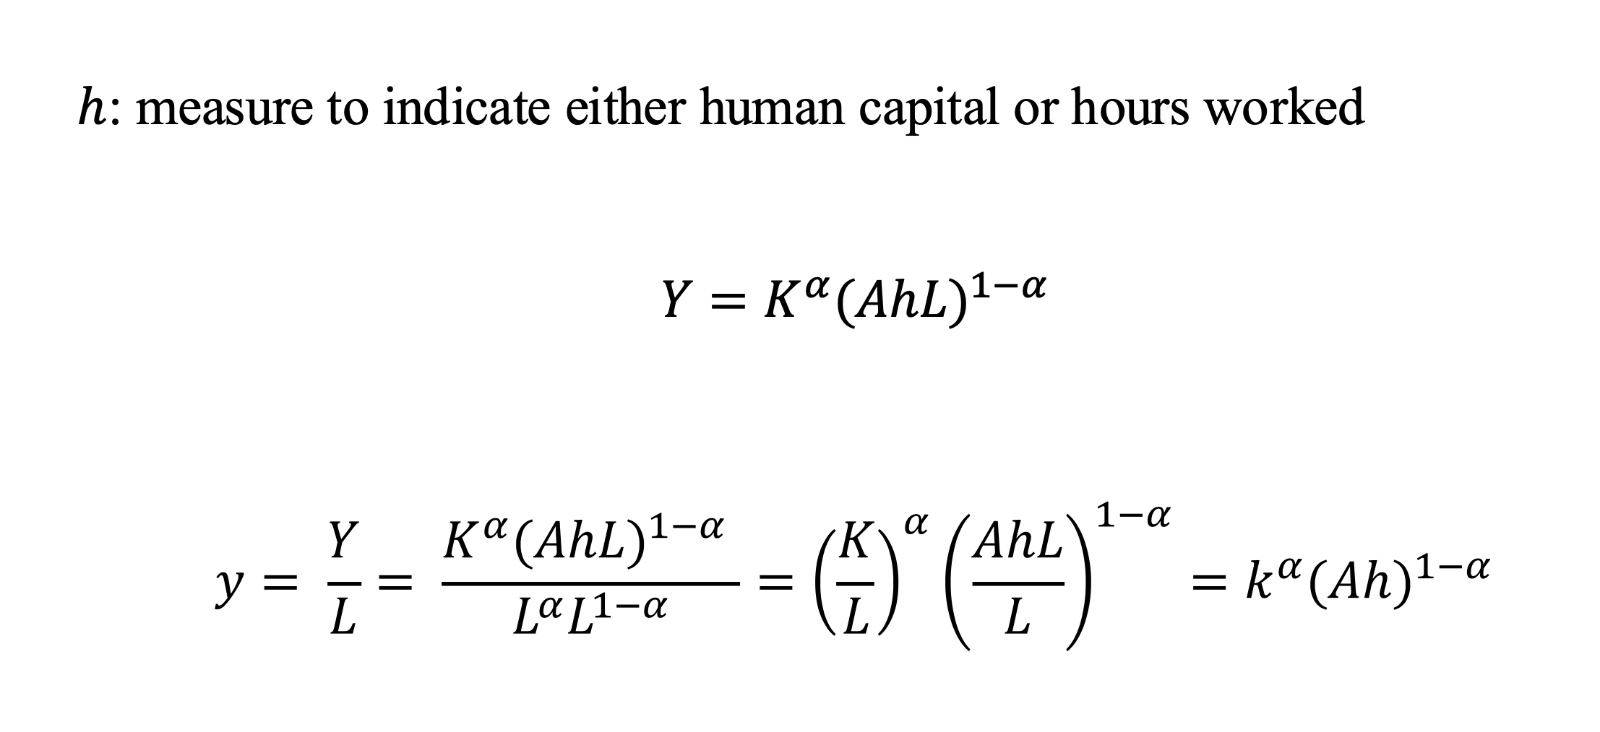
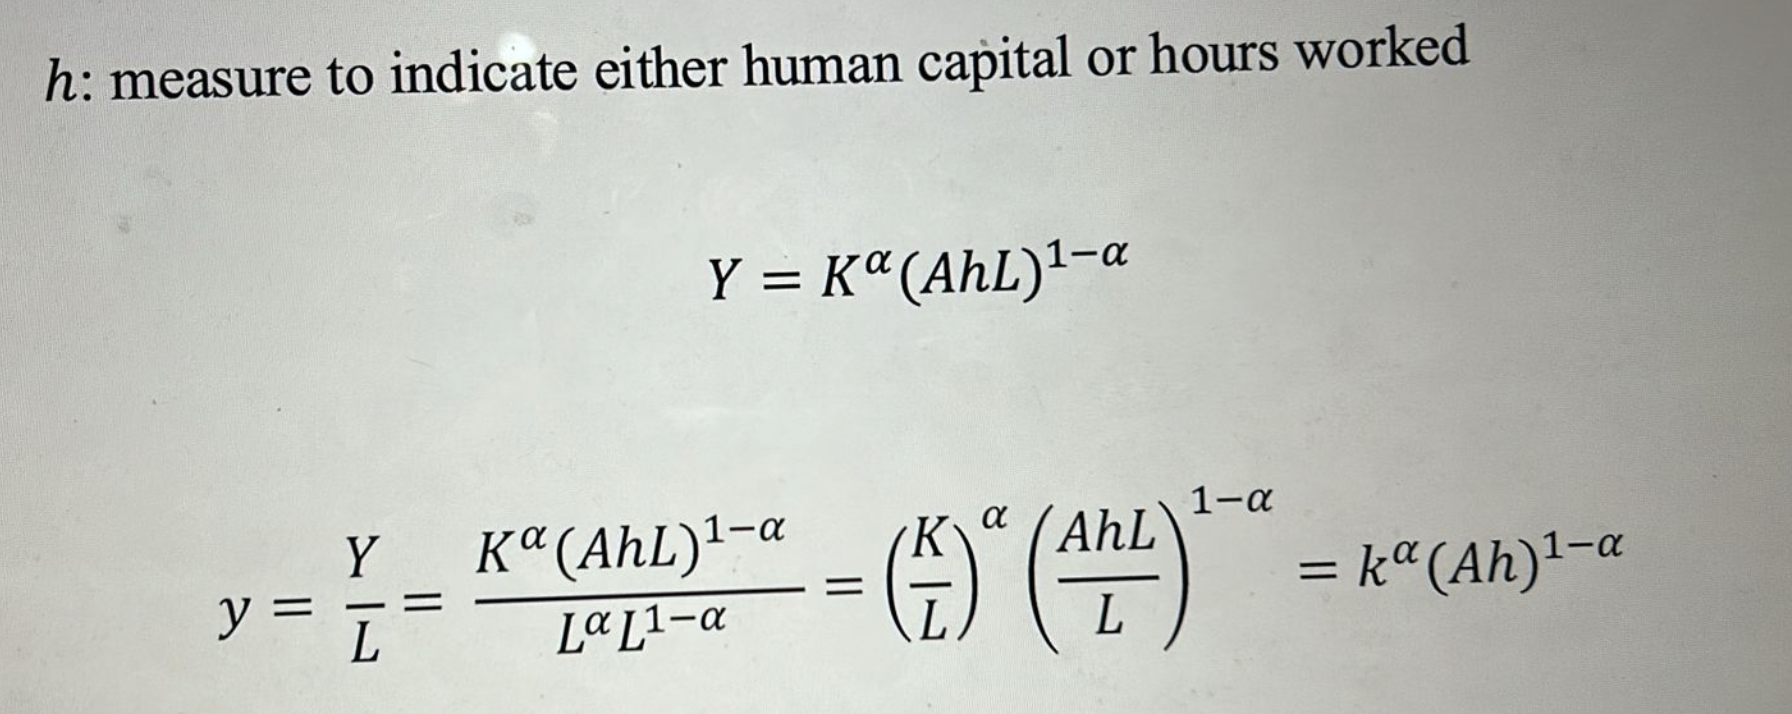

year         rgdpna        emp         rnna        hc  TFP_alpha_0.25  \
0  1960  147538.921875  28.498953  762376.7500  1.158581     2584.620672   
1  1961  159648.609375  29.060551  765323.1875  1.176857     2768.498671   
2  1962  159406.125000  29.569380  764462.1875  1.195421     2674.185813   
3  1963  153244.640625  30.088734  756324.5000  1.214278     2463.517674   
4  1964  160370.234375  30.618654  751605.5625  1.233432     2537.466753   

   TFP_alpha_0.3  TFP_alpha_0.35  
0    2210.380296     1845.382708  
1    2384.611743     2007.325066  
2    2303.290030     1938.785826  
3    2116.045162     1775.561034  
4    2190.323887     1848.360916

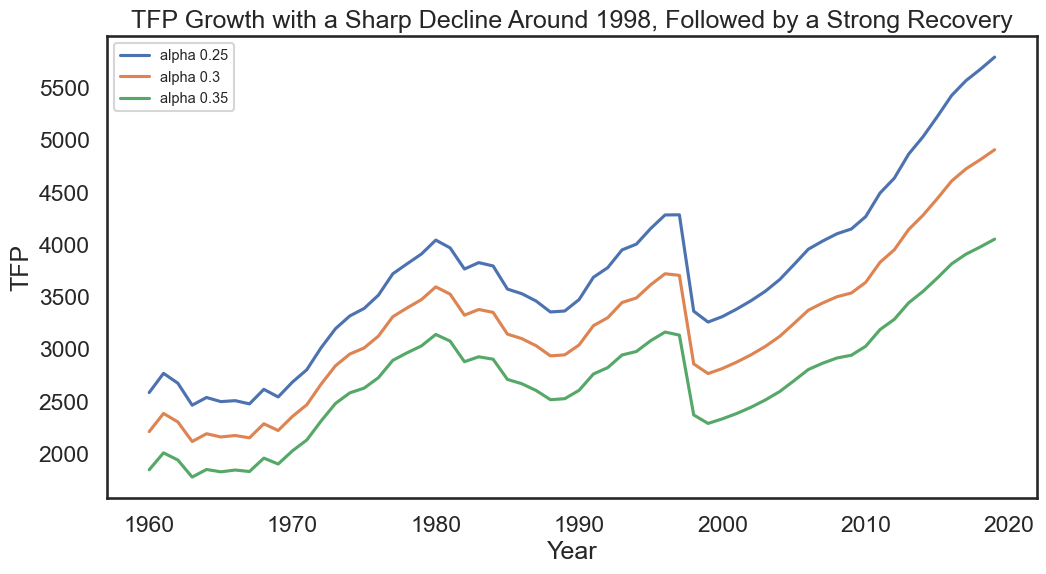

In [11]:
# Calculating TFP

data = pd.read_excel('pwt100.xlsx', sheet_name='Data', header=0)

# Extract relevant variables and select Indonesia
data_indonesia_b = data.loc[data["country"] == "Indonesia", ["year", "rgdpna", "emp", "rnna", "hc"]]

# Drop rows with missing values
data_indonesia_b.dropna(subset=["rgdpna", "emp", "rnna", "hc"], inplace=True)

# Define alpha values for robustness check
alpha_values = [0.25, 0.3, 0.35]

# Calculate TFP for each alpha
tfp_results = {f"TFP_alpha_{alpha}": 
               (1 / (data_indonesia_b["emp"] * data_indonesia_b["hc"])) * 
               (data_indonesia_b["rgdpna"] / (data_indonesia_b["rnna"]) ** alpha) ** (1 / (1 - alpha)) 
               for alpha in alpha_values}

# Convert results to DataFrame and merge with original DataFrame
tfp_df = pd.DataFrame(tfp_results)
tfp_df["year"] = data_indonesia_b["year"]
data_indonesia_b = data_indonesia_b.merge(tfp_df, on="year")

# Display DataFrame
display(data_indonesia_b.head())

# Plot Time Series of TFP
plt.figure(figsize=(12, 6))
for alpha in alpha_values:
    plt.plot(data_indonesia_b['year'], data_indonesia_b[f"TFP_alpha_{alpha}"], label=f"alpha {alpha}")

# Labels and Title
plt.xlabel("Year")
plt.ylabel("TFP")
plt.legend(fontsize='xx-small', loc='upper left')
plt.title("TFP Growth with a Sharp Decline Around 1998, Followed by a Strong Recovery")

# Show plot
plt.show()


### **3.3 Growth Accounting**

Calculated average growth rates for GDP, capital, labour (adjusted by human capital), and TFP over six decades. 

Proportional contributions of each input were analysed, and a time series plot was created to highlight their impact on long-term GDP growth.


In [12]:
# Growth Accounting - Data Preparation
# Ensure the year column is of integer type
data_indonesia_b["year"] = data_indonesia_b["year"].astype(int)

# Display the updated DataFrame
display(data_indonesia_b.head())


year         rgdpna        emp         rnna        hc  TFP_alpha_0.25  \
0  1960  147538.921875  28.498953  762376.7500  1.158581     2584.620672   
1  1961  159648.609375  29.060551  765323.1875  1.176857     2768.498671   
2  1962  159406.125000  29.569380  764462.1875  1.195421     2674.185813   
3  1963  153244.640625  30.088734  756324.5000  1.214278     2463.517674   
4  1964  160370.234375  30.618654  751605.5625  1.233432     2537.466753   

   TFP_alpha_0.3  TFP_alpha_0.35  
0    2210.380296     1845.382708  
1    2384.611743     2007.325066  
2    2303.290030     1938.785826  
3    2116.045162     1775.561034  
4    2190.323887     1848.360916

In [13]:
# Initialise dataframe with NaNs for storing average growth rates
avg_growth_rates = pd.DataFrame(
    data=np.full((6, 5), np.nan),
    columns=['Y growth', 'K growth', 'L growth', 'h growth', 'A growth']
)
avg_growth_rates['year'] = ["1960-1970", "1970-1980", "1980-1990", "1990-2000", "2000-2010", "2010-2019"]
avg_growth_rates = avg_growth_rates.set_index('year')

# Set alpha = 0.3 
alpha = 0.3

# Fill with average growth rates from data_indonesia_b
cols = ['rgdpna', 'rnna', 'emp', 'hc', 'TFP_alpha_0.3']

# Ensure the years exist in the DataFrame
years = [1960, 1970, 1980, 1990, 2000, 2010, 2019]
for start, end in zip(years[:-1], years[1:]):
    if {start, end}.issubset(data_indonesia_b["year"].values):
        avg_growth_rates.loc[f"{start}-{end}"] = np.log(
            data_indonesia_b.loc[data_indonesia_b["year"] == end, cols].values /
            data_indonesia_b.loc[data_indonesia_b["year"] == start, cols].values
        ).flatten()

# Display the average growth rates
display(avg_growth_rates)


Y growth  K growth  L growth  h growth  A growth
year                                                       
1960-1970  0.281279  0.009737  0.177141  0.156511  0.064003
1970-1980  0.767951  0.629118  0.290938  0.113824  0.422690
1980-1990  0.608867  0.779229  0.481935  0.221849 -0.167929
1990-2000  0.413341  0.718852  0.216988  0.142541 -0.077121
2000-2010  0.510038  0.477054  0.166694  0.100511  0.256969
2010-2019  0.466961  0.535723  0.192936 -0.054682  0.299236

In [14]:
# Compute contribution rates
df_contribs_long = avg_growth_rates.copy()
df_contribs_long['K contribution'] = alpha * (df_contribs_long['K growth'] / df_contribs_long['Y growth'])
df_contribs_long['h contribution'] = (1 - alpha) * (df_contribs_long['h growth'] / df_contribs_long['Y growth'])
df_contribs_long['L contribution'] = (1 - alpha) * (df_contribs_long['L growth'] / df_contribs_long['Y growth'])
df_contribs_long['A contribution'] = (1 - alpha) * (df_contribs_long['A growth'] / df_contribs_long['Y growth'])

# Create dataframe of the contributions
df_contribs = df_contribs_long[['Y growth', 'K contribution', 'h contribution', 'L contribution', 'A contribution']]

# Display dataframe of the contributions
display(df_contribs.head())


Y growth  K contribution  h contribution  L contribution  \
year                                                                  
1960-1970  0.281279        0.010385        0.389497        0.440837   
1970-1980  0.767951        0.245765        0.103752        0.265194   
1980-1990  0.608867        0.383940        0.255054        0.554069   
1990-2000  0.413341        0.521737        0.241396        0.367473   
2000-2010  0.510038        0.280599        0.137946        0.228779   

           A contribution  
year                       
1960-1970        0.159280  
1970-1980        0.385288  
1980-1990       -0.193064  
1990-2000       -0.130606  
2000-2010        0.352676

In [15]:
# Create dataframe of the growth rates
df_contribs_growth_rates = df_contribs_long[['Y growth', 'K growth', 'h growth', 'L growth', 'A growth']]
display(df_contribs_growth_rates.head())

# Calculate the sum of A growth, h growth, and L growth
df_contribs_growth_rates_sum = df_contribs_growth_rates.copy()
df_contribs_growth_rates_sum.loc[:, 'Sum of A, h, L growth'] = (
    df_contribs_growth_rates_sum['A growth'] +
    df_contribs_growth_rates_sum['h growth'] +
    df_contribs_growth_rates_sum['L growth']
)

# Calculate the difference between gA+gL+gh and gY 
df_contribs_growth_rates_sum.loc[:, 'Difference'] = (
    df_contribs_growth_rates_sum['Sum of A, h, L growth'] - df_contribs_growth_rates_sum['Y growth']
)

# Create a new dataframe with sub-periods as rows, and columns for gY and the sum of A, h, L growth
df_table = df_contribs_growth_rates_sum[['Y growth', 'Sum of A, h, L growth', 'Difference']]

# Display the resulting dataframe
display(df_table.head())


Y growth  K growth  h growth  L growth  A growth
year                                                       
1960-1970  0.281279  0.009737  0.156511  0.177141  0.064003
1970-1980  0.767951  0.629118  0.113824  0.290938  0.422690
1980-1990  0.608867  0.779229  0.221849  0.481935 -0.167929
1990-2000  0.413341  0.718852  0.142541  0.216988 -0.077121
2000-2010  0.510038  0.477054  0.100511  0.166694  0.256969

Y growth  Sum of A, h, L growth  Difference
year                                                  
1960-1970  0.281279               0.397654    0.116375
1970-1980  0.767951               0.827451    0.059500
1980-1990  0.608867               0.535855   -0.073012
1990-2000  0.413341               0.282408   -0.130933
2000-2010  0.510038               0.524174    0.014136

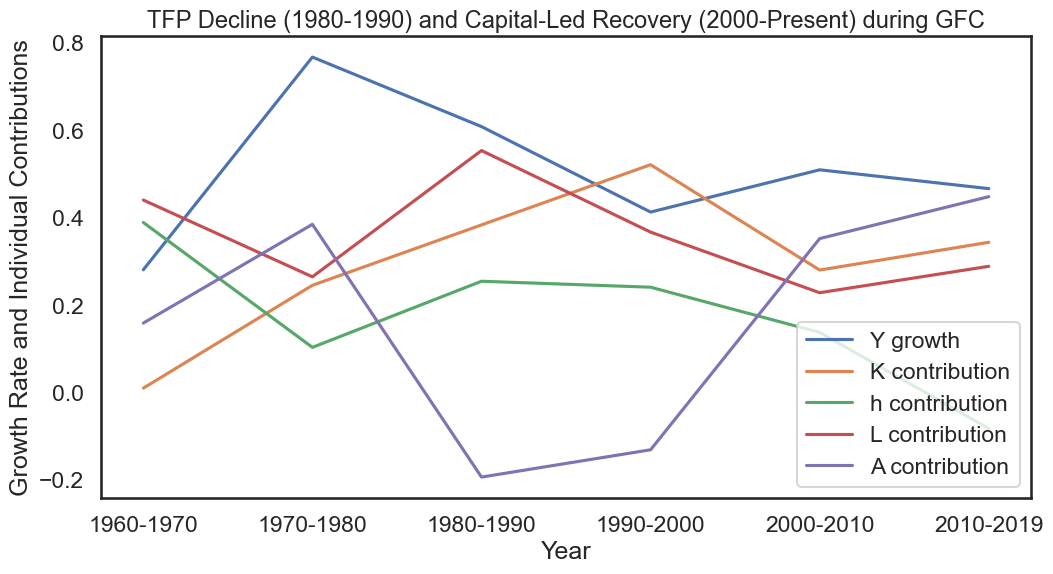

In [16]:
# Plotting the time series of contributions
plt.figure(figsize=(12, 6))
plt.plot(df_contribs_long.index, df_contribs_long['Y growth'], label='Y growth')
plt.plot(df_contribs_long.index, df_contribs_long['K contribution'], label='K contribution')
plt.plot(df_contribs_long.index, df_contribs_long['h contribution'], label='h contribution')
plt.plot(df_contribs_long.index, df_contribs_long['L contribution'], label='L contribution')
plt.plot(df_contribs_long.index, df_contribs_long['A contribution'], label='A contribution')

# Adding titles and labels
plt.title('TFP Decline (1980-1990) and Capital-Led Recovery (2000-Present) during GFC', fontsize=17)
plt.xlabel('Year')
plt.ylabel('Growth Rate and Individual Contributions')
plt.legend()

# Display the plot
plt.show()


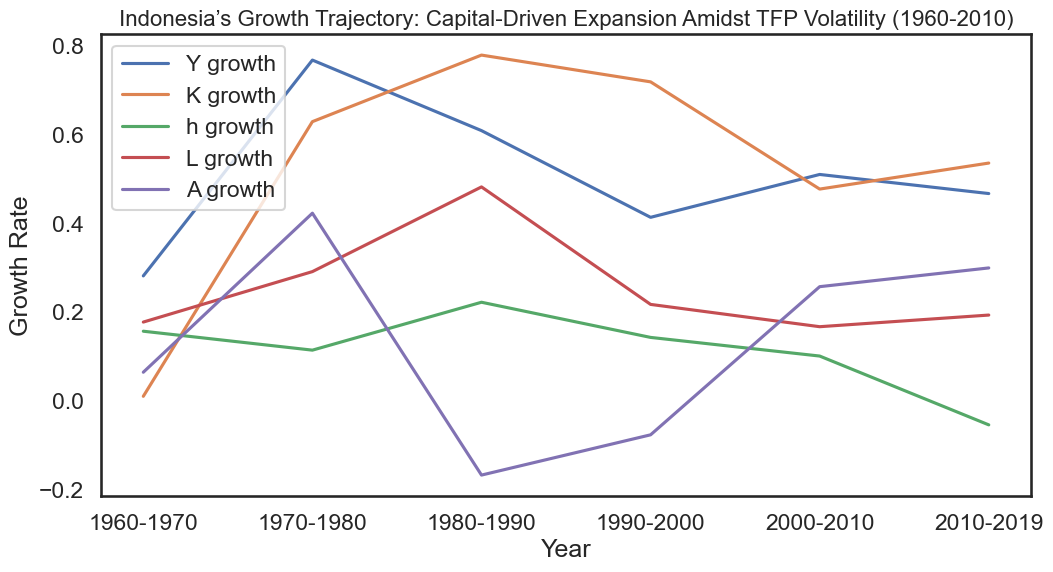

In [17]:
# Plotting the time series of growth rates
plt.figure(figsize=(12, 6))
plt.plot(df_contribs_long.index, df_contribs_long['Y growth'], label='Y growth')
plt.plot(df_contribs_long.index, df_contribs_long['K growth'], label='K growth')
plt.plot(df_contribs_long.index, df_contribs_long['h growth'], label='h growth')
plt.plot(df_contribs_long.index, df_contribs_long['L growth'], label='L growth')
plt.plot(df_contribs_long.index, df_contribs_long['A growth'], label='A growth')

# Adding titles and labels
plt.title('Indonesia’s Growth Trajectory: Capital-Driven Expansion Amidst TFP Volatility (1960-2010)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.legend()

# Display the plot
plt.show()


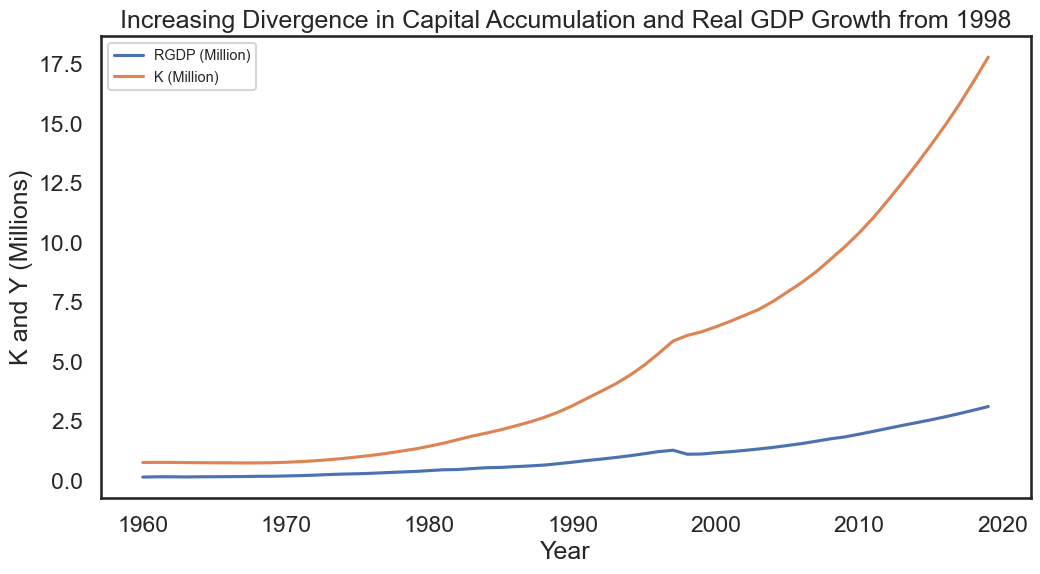

In [18]:
# Scale Y and K to millions
data_indonesia_b["rgdpna_million"] = data_indonesia_b["rgdpna"] / 1e6
data_indonesia_b["rnna_million"] = data_indonesia_b["rnna"] / 1e6

# Plotting the time series of Y and K in millions
plt.figure(figsize=(12, 6))
plt.plot(data_indonesia_b['year'], data_indonesia_b["rgdpna_million"], label="RGDP (Million)")
plt.plot(data_indonesia_b['year'], data_indonesia_b["rnna_million"], label="K (Million)")

# Labels
plt.xlabel("Year")
plt.ylabel("K and Y (Millions)")
plt.legend(fontsize='xx-small', loc='upper left')

# Title
plt.title("Increasing Divergence in Capital Accumulation and Real GDP Growth from 1998")

# Show plot
plt.show()



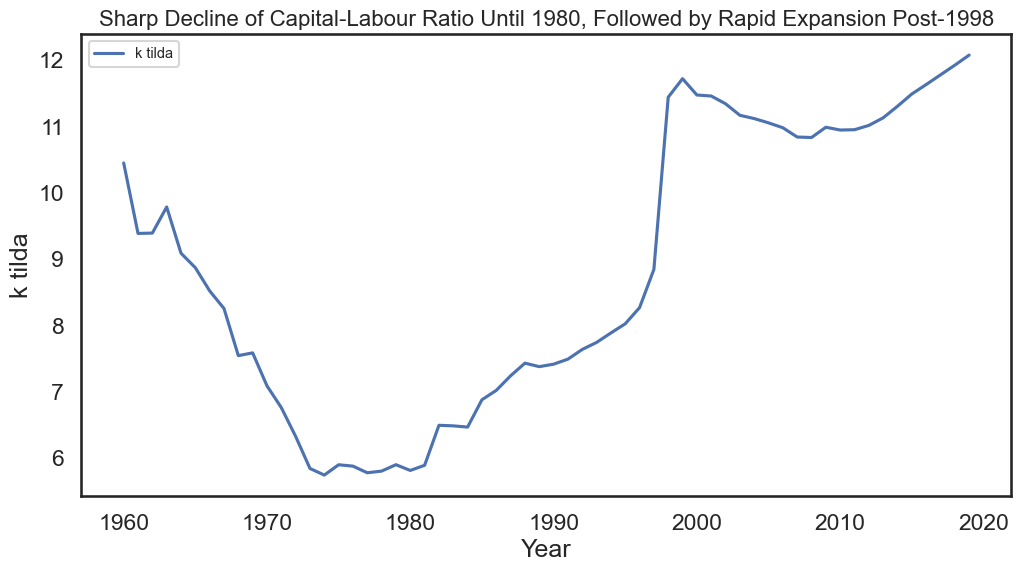

In [19]:
# Create k tilda variable and add it to the DataFrame
data_indonesia_b["k_tilda"] = data_indonesia_b["rnna"] / (data_indonesia_b["TFP_alpha_0.3"] * data_indonesia_b["hc"] * data_indonesia_b["emp"]) 

# Plotting the time series of k tilda 
plt.figure(figsize=(12, 6))
plt.plot(data_indonesia_b['year'], data_indonesia_b["k_tilda"], label="k tilda")

# Labels
plt.xlabel("Year")
plt.ylabel("k tilda")
plt.legend(fontsize='xx-small', loc='upper left')

# Title
plt.title("Sharp Decline of Capital-Labour Ratio Until 1980, Followed by Rapid Expansion Post-1998", fontsize=16)

# Show plot
plt.show()


### **3.3.2 Stacked Contributions to Output Growth Over Time**  
This chart shows the contributions of total factor productivity, labour, human capital, and capital to output growth across different time periods.

The x-axis is centred at 0.5 for clearer comparison, and the stacked bars highlight the relative impact of each factor over time.

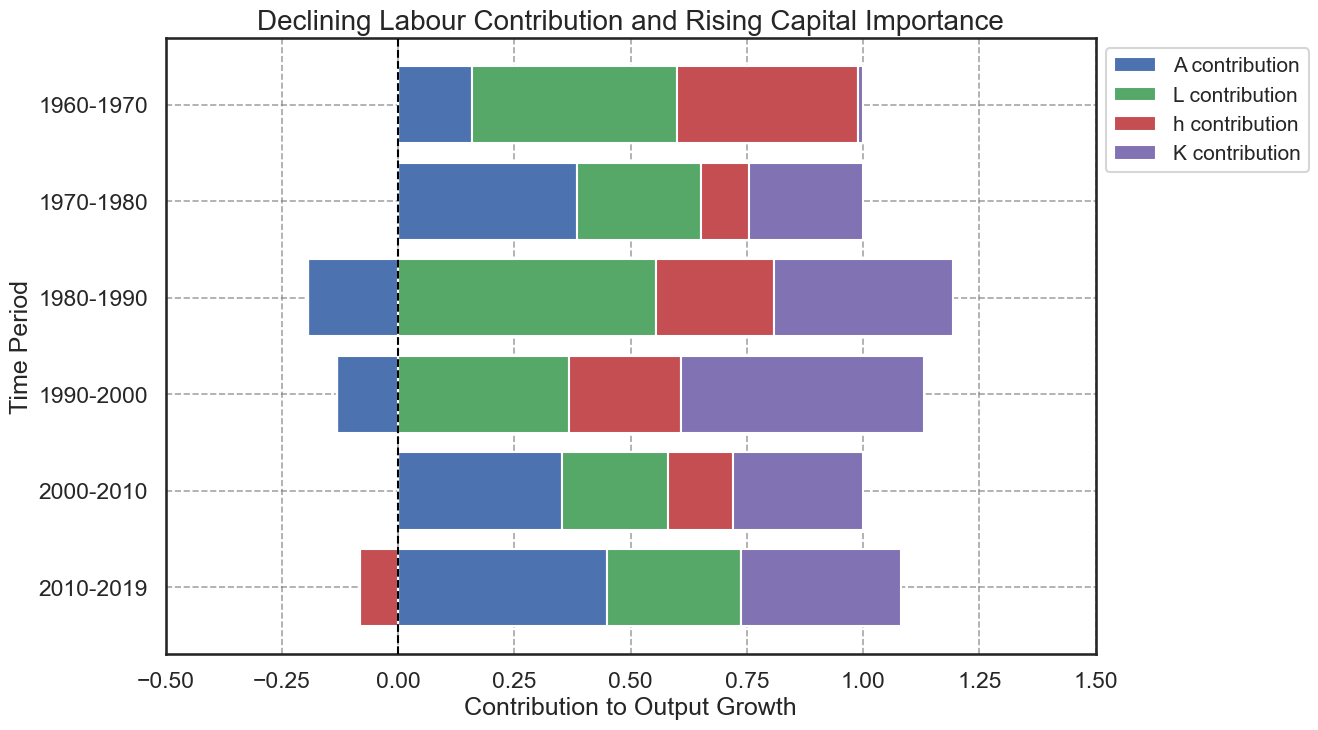

In [20]:
# Reverse the order of time periods for better readability
categories = df_contribs_long.index[::-1]  

# Extract contribution values
k_contribution = df_contribs_long['K contribution'][::-1].values
h_contribution = df_contribs_long['h contribution'][::-1].values
l_contribution = df_contribs_long['L contribution'][::-1].values
a_contribution = df_contribs_long['A contribution'][::-1].values

# Separate positive and negative contributions
k_pos, k_neg = np.where(k_contribution > 0, k_contribution, 0), np.where(k_contribution < 0, k_contribution, 0)
h_pos, h_neg = np.where(h_contribution > 0, h_contribution, 0), np.where(h_contribution < 0, h_contribution, 0)
l_pos, l_neg = np.where(l_contribution > 0, l_contribution, 0), np.where(l_contribution < 0, l_contribution, 0)
a_pos, a_neg = np.where(a_contribution > 0, a_contribution, 0), np.where(a_contribution < 0, a_contribution, 0)

# Define professional color palette
colors = {
    "A contribution": "#4C72B0",  # Deep Blue
    "L contribution": "#55A868",  # Muted Green
    "h contribution": "#C44E52",  # Muted Red
    "K contribution": "#8172B3",  # Deep Purple
}

# Set figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Stack positive contributions
ax.barh(categories, a_pos, label="A contribution", color=colors["A contribution"], zorder=3)
ax.barh(categories, l_pos, left=a_pos, label="L contribution", color=colors["L contribution"], zorder=3)
ax.barh(categories, h_pos, left=a_pos + l_pos, label="h contribution", color=colors["h contribution"], zorder=3)
ax.barh(categories, k_pos, left=a_pos + l_pos + h_pos, label="K contribution", color=colors["K contribution"], zorder=3)

# Stack negative contributions separately (left side)
ax.barh(categories, a_neg, color=colors["A contribution"], zorder=3)
ax.barh(categories, l_neg, left=a_neg, color=colors["L contribution"], zorder=3)
ax.barh(categories, h_neg, left=a_neg + l_neg, color=colors["h contribution"], zorder=3)
ax.barh(categories, k_neg, left=a_neg + l_neg + h_neg, color=colors["K contribution"], zorder=3)

# Set x-axis limits from -0.5 to 1.5 for better centering
ax.set_xlim(-0.5, 1.5)

# Add a bold dashed reference line at 0
ax.axvline(x=0, color='black', linestyle="dashed", linewidth=1.5, zorder=4)

# Add equally bold dashed grid lines
ax.grid(True, which='both', axis='both', color='grey', linestyle='--', linewidth=1.2, alpha=0.7, zorder=2)

# Labels and title
ax.set_xlabel("Contribution to Output Growth")
ax.set_ylabel("Time Period")
ax.set_title("Declining Labour Contribution and Rising Capital Importance", fontsize=20)

# Move legend outside the plot
ax.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()


### **3.4 Labour Productivity**

Labour productivity, measured as GDP per worker, was calculated to track economic efficiency. 

A time series plot compares labour productivity with Total Factor Productivity (TFP) to show their trends over time in Indonesia's growth.


#### **3.4.1 Time Series of TFP and Labour Productivity**

This section examines the trends in **Total Factor Productivity (TFP)** and **labour productivity** over time, highlighting their contributions to economic growth and structural changes in Indonesia’s economy.

year  labour_productivity
0  1960          5176.994487
1  1961          5493.653960
2  1962          5390.918783
3  1963          5093.090400
4  1964          5237.664368

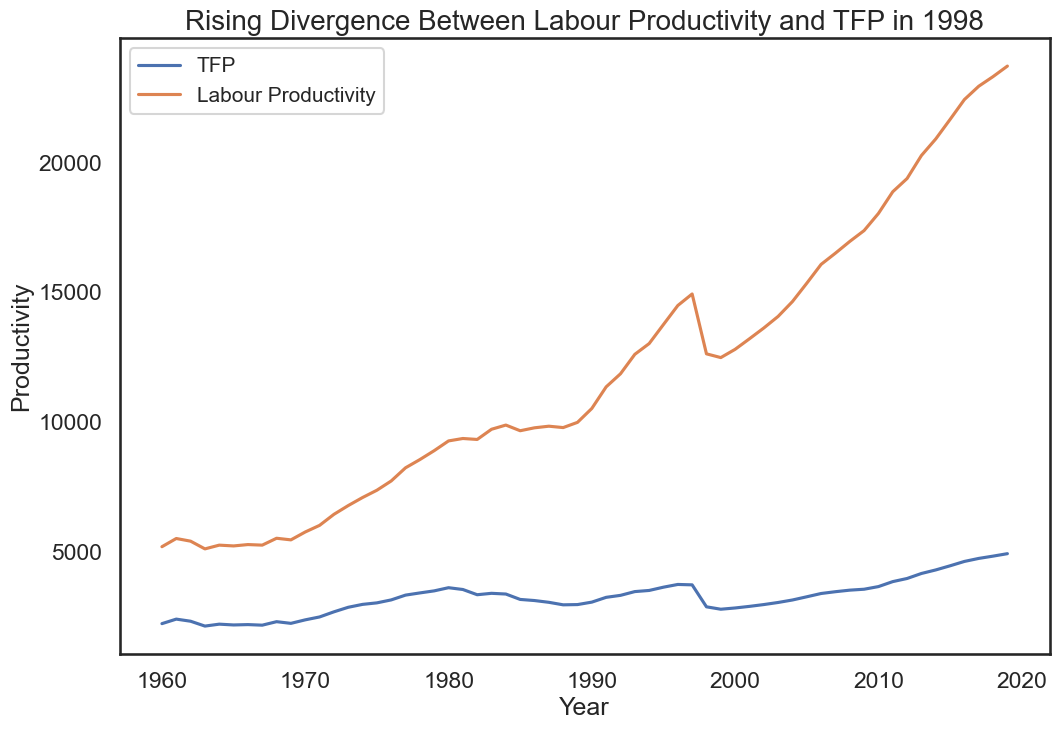

In [21]:
# Labour Productivity 
# Calculate labour productivity (GDP per worker)
data_indonesia_b["labour_productivity"] = data_indonesia_b["rgdpna"] / data_indonesia_b["emp"]

# Display the updated DataFrame
display(data_indonesia_b[["year", "labour_productivity"]].head())

# Plot Time Series with larger figure size
plt.figure(figsize=(12, 8))  
plt.plot(data_indonesia_b['year'], data_indonesia_b["TFP_alpha_0.3"], label="TFP")
plt.plot(data_indonesia_b['year'], data_indonesia_b["labour_productivity"], label="Labour Productivity")

# Labels
plt.xlabel("Year")
plt.ylabel("Productivity")
plt.legend(fontsize='small', loc='upper left')

# Title
plt.title("Rising Divergence Between Labour Productivity and TFP in 1998", fontsize=20)

# Render the plot
plt.show()


#### **3.4.2 Normalised Time Series of TFP and Labour Productivity**


To ensure **TFP** and **labour productivity** are on a comparable scale, we normalise them by setting **1960 as the base year** and dividing all values by their respective 1960 values. 

We then take the **log** of these normalised values, allowing the **slope of the curves to represent growth rates** over time.



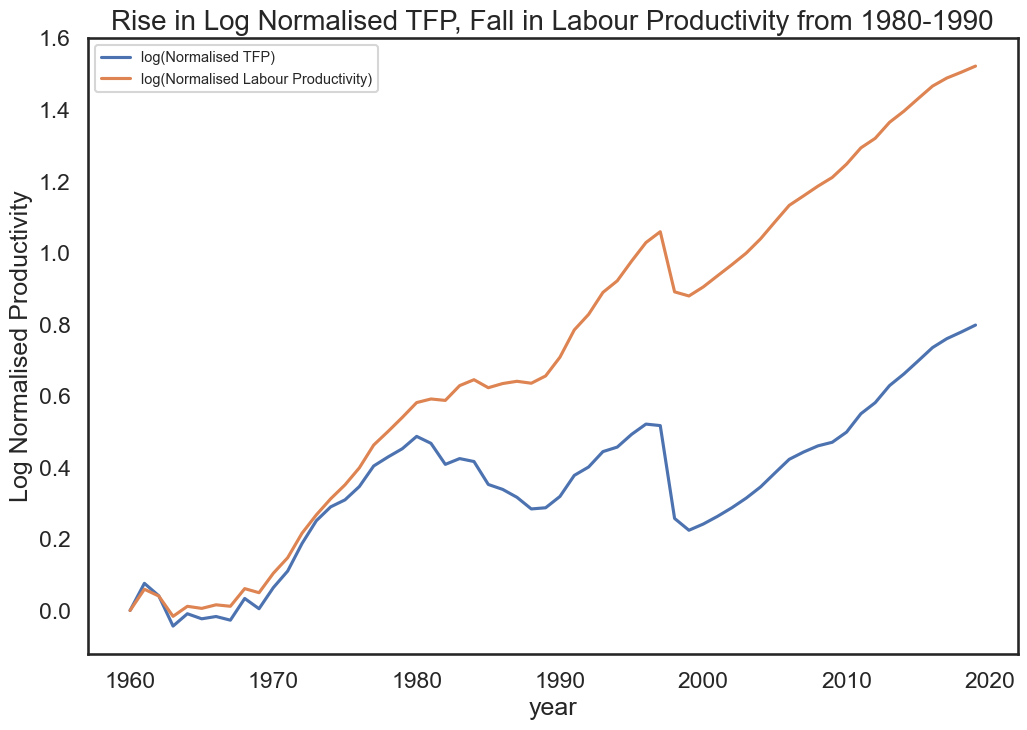

In [23]:
# Normalize labour productivity and TFP by dividing by the first year value
data_indonesia_b["labour_productivity_normalized"] = data_indonesia_b["labour_productivity"] / data_indonesia_b["labour_productivity"].iloc[0]
data_indonesia_b["TFP_normalized"] = data_indonesia_b["TFP_alpha_0.3"] / data_indonesia_b["TFP_alpha_0.3"].iloc[0]

# Take the natural logarithm of the normalized values
data_indonesia_b["ln_labour_productivity_normalized"] = np.log(data_indonesia_b["labour_productivity_normalized"])
data_indonesia_b["ln_TFP_normalized"] = np.log(data_indonesia_b["TFP_normalized"])

# Plot Time Series
plt.figure(figsize=(12, 8)) 
plt.plot(data_indonesia_b['year'], data_indonesia_b["ln_TFP_normalized"], label="TFP")
plt.plot(data_indonesia_b['year'], data_indonesia_b["ln_labour_productivity_normalized"], label="Labour Productivity")
# Labels
plt.xlabel("year")
plt.ylabel("Log Normalised Productivity")
plt.legend(['log(Normalised TFP)', 'log(Normalised Labour Productivity)'], fontsize='xx-small', loc='upper left')

# Title
plt.title("Rise in Log Normalised TFP, Fall in Labour Productivity from 1980-1990", fontsize=20)
plt.show()